# MC Dropout as Bayesian Approximation Notebook

Goal: A complete workflow with prototypical functions that I'll be using for all the other workflows.

Some of the workflow will be taken from my code from Statistical NLP module.
* Ideally it's not too difficult to swap things like the dropout regime, training schedule etc
* Need to have a training manager that saves and logs data
* Better way to define UNet - also possibly easy to switch out other networks would be nice

10th June: Complete notebook sketch

# Installs & Imports

In [1]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary
from tqdm.notebook import tqdm

# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


## Import dataset

Currently I import from google drive to keep the flexibility of able to import eval set here as well.
If I just need training set we could use git clone to get the zip file.

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

# copy dataset to local env
if 'mastr' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
  !unzip -q 'mastr.zip' -d mastr
  !rm 'mastr.zip'


Mounted at /content/drive/


# Process Data

### Define some global variables

In [41]:
# Global variables
CLASS_MAP_ALL = {0: 'obstacle', 1: 'water', 2: 'sky', 3: 'ambiguous', 4: 'remove'} # 3 and 4 should not be fed into the network
CLASS_MAP = {0: 'obstacle', 1: 'water', 2: 'sky'} # only valid classes
NUM_CLASSES = len(CLASS_MAP.keys())
SEED = 0

# dummy pixel (placed at boundaries), we want to change it from 4 to 3, then drop it in the end
DROP_PIX = 4
FILL_PIX = 3

TRAINING_PATH = '/content/mastr/'
IMAGE_DIR = TRAINING_PATH + 'images/'
LABEL_DIR = TRAINING_PATH + 'masks/'

## Dataset Definition

Two definitions for dataset:
* `OnlineDataset` doesn't store the processed images and reads them from the drive's local folder, used for evaluation dataset
* `MemoryDataset` loads all the images into memory. This only works for the training set which is relatively small.

In [4]:
class OnlineDataset(Dataset):
    def __init__(self, x_dir, y_dir, transform=None):
        '''
        Online dataset that takes directories as inputs and loads the images

        Args
        ------
        x_dir : str, directory holding images (e.g. /content/mastr/images)
        y_dir : str, directory holding labels (e.g. /content/mastr/masks)
        transforms : transforms.Compose([...])
        '''
        self.y_dir = y_dir
        self.x_dir = x_dir
        self.transform = transform

        # This list is used to index all the images in the directory
        # image and labels share same prefix in the names
        self.x_file_names = os.listdir(x_dir)

    def __len__(self):
        return len(os.listdir(self.x_dir))

    def __getitem__(self, idx):
        # get image and label path
        x_path = os.path.join(self.x_dir, self.x_file_names[idx])
        # TODO: can refactor this if other dataset are used
        y_path = os.path.join(
            self.y_dir, self.x_file_names[idx].replace(".jpg", "m.png"))

        x = read_image(x_path)
        y = read_image(y_path)

        # NOTE: image format(C, W, H)

        if self.transform:
            x, y = self.transform((x, y))

        return x, y

class MemoryDataset(Dataset):
    def __init__(self, X, y, transform=None):
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, 384, 512)
        y : Tensor with shape (n, 1, 384, 512)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            x, y = self.transform((x, y))
        return x, y

## Transformation
All the transformations are performed using `torchvision.transforms` or `transforms.functional`.
* `HFlip`: Horizontal flip
* `HueSatCon`: Brightness, contrast, saturation, and hue (always applied)
* `Affine`: Translation and Shear
* `Rotation`: Rotate
* `Crop`
* `Resize`

The transformations should be performed in the order above, the goal is to emulate scenes similar to shoreline images, thus ordering matters. E.g. Horizontal shear followed by rotate is preferred compared to the other way around.

In [5]:
# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

# Only on tensors!
class HFlip(object):
    def __init__(self, prob=0.5):
        self.flip_transform = transforms.RandomHorizontalFlip(1)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          x = self.flip_transform(x)
          y = self.flip_transform(y)

        return (x, y)

class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob=1):
        self.hue_transform = transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob and x!= None:
            x = self.hue_transform(x)
        return (x, y)

class Rotation(object):
    def __init__(self, angle, prob=1):
        self.angle = angle
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # comptute random angle to rotate for this instance
          rot_angle = (random.random()*2-1) * self.angle
          x = transforms.functional.rotate(x, rot_angle, expand=False)
          y = transforms.functional.rotate(y, rot_angle, expand=False, fill=FILL_PIX)
        return (x, y)

class Crop(object):
    def __init__(self, crop_percentage, prob=1):
        self.crop_percentage = crop_percentage
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # compute random crop proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length
          # percentage crop in the horizontal direction
          crop1 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # percentage crop in the vertical direction
          crop2 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # compute all the arguments for TF.crop()
          width = int(crop1 * dim2)
          height = int(crop2 * dim1)
          left = int(random.random() * ((1-crop1)/2) * dim1)
          top = int(random.random() * ((1-crop2)/2) * dim2)

          x = transforms.functional.crop(x, top, left, height, width)
          y = transforms.functional.crop(y, top, left, height, width)

        return (x, y)

# Translation and Shear
class Affine(object):
    def __init__(self, affine_percentage, shear_deg, prob=1):
        self.affine_percentage = affine_percentage # (e.g. 0.1)
        self.shear_deg = shear_deg # in deg (e.g. 15)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data

        p = random.random()
        if p < self.prob:
          # compute random affine proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length

          # translation offset for this instance
          offset1 = (random.random() * 2 - 1) * dim1 * self.affine_percentage
          offset2 = (random.random() * 2 - 1) * dim2 * self.affine_percentage
          # shear deg for this instance
          shear = (random.random() * 2 - 1) * self.shear_deg

          # apply affine transformation
          x = torchvision.transforms.functional.affine(x, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.BILINEAR)
          y = torchvision.transforms.functional.affine(y, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.NEAREST, fill=FILL_PIX)
        return (x, y)

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)
        self.resize_y = transforms.Resize(size, transforms.InterpolationMode.NEAREST, antialias=True) #nearest-exact?

    def __call__(self, data):
        x, y = data
        x = self.resize_x(x)
        y = self.resize_y(y)

        return (x, y)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, move_to_device=True):
        self.to_tensor = transforms.PILToTensor()
        self.move = move_to_device

    def __call__(self, data):
        x, y = data

        x = self.to_tensor(x)
        y = self.to_tensor(y)

        if self.move:
          x = x.to(DEVICE)
          y = y.to(DEVICE)

        # Normalize - TODO
        # x = x / 255.0

        imageNet_normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        x = imageNet_normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

class Normalize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, data):
        x, y = data
        x = self.Normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

## Train-val split

In [6]:
def train_val_test_split(X, y, train_ratio, val_ratio):
  '''
  splits the dataset into train and validation sets
  '''
  torch.manual_seed(SEED) # !important

  n = X.shape[0]

  perm = torch.randperm(n)

  tr_ratio = train_ratio / (train_ratio+val_ratio)
  v_ratio = val_ratio / (train_ratio+val_ratio)

  tr_n = int(tr_ratio * n)
  val_n = int(v_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:]], y[perm[tr_n:]]

  return X_train, y_train, X_val, y_val

## Load MaSTr1325
Load entire training set into memory and create dataset objects

In [7]:
# load all of training data into memory
def load_mastr(img_dir, mask_dir):
    '''Load all data into memory '''
    img_file_names = os.listdir(img_dir)
    n = len(img_file_names)
    # preallocate tensor memory
    X = torch.zeros((n, 3, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)

    for i in tqdm(range(n)):
      img_path = os.path.join(img_dir, img_file_names[i])
      mask_path = os.path.join(
          mask_dir, img_file_names[i].replace(".jpg", "m.png"))

      x = read_image(img_path)
      y = read_image(mask_path)

      x = x / 255.0
      y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return X, Y

In [8]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = None, None, None, None
X_raw, y_raw = load_mastr(IMAGE_DIR, LABEL_DIR)
print(f'Number of total images: {len(X_raw)}')

  0%|          | 0/1325 [00:00<?, ?it/s]

Number of total images: 1325


### Split dataset

Number of training images: 1225
Number of validation images: 100


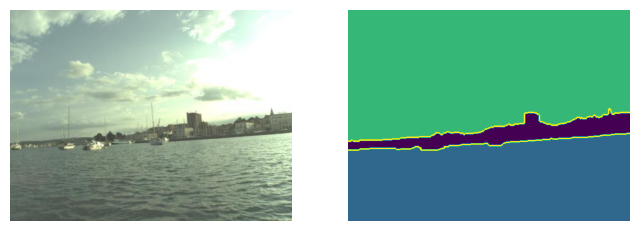

In [9]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = train_val_test_split(X_raw, y_raw, 1225, 100)
print(f'Number of training images: {len(X_train_raw)}')
print(f'Number of validation images: {len(X_val_raw)}')

# show sample image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')

del X_raw, y_raw

### Dataset objects



In [10]:
# define transformations
train_transforms = transforms.Compose([
    HFlip(prob=0.5),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Affine(affine_percentage=0.1, shear_deg=5, prob=1),
    Rotation(10, prob=1),
    Crop(crop_percentage=0.9, prob=1),
    Resize((224, 224)),
    Normalize(),
])

val_transforms = transforms.Compose([
    Resize((224, 224)),
    Normalize(),
])

In [11]:
train_dataset = MemoryDataset(X_train_raw, y_train_raw, train_transforms)
val_dataset = MemoryDataset(X_val_raw, y_val_raw, val_transforms)

## DataLoader Definition

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': None}

### Preview example images

These are images that will be fed into the network

In [13]:
def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

In [14]:
# x_batch_sample, y_batch_sample = next(iter(train_dataloader))

# plt.figure(figsize=(8, 3))
# for i in range(3):
#   plt.subplot(1, 6, i*2+1)
#   plt.imshow(unnormalize(x_batch_sample[i]).permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.subplot(1, 6, i*2+2)
#   plt.imshow(y_batch_sample[i].permute(1, 2, 0).cpu())
#   plt.axis('off')

# # note: clipping error message can be ignored
# plt.tight_layout()


# # VALIDATION IMAGES
# plt.figure(figsize=(8, 3))
# for i in range(3):
#   x, y = next(iter(val_dataloader))
#   plt.subplot(1, 6, i*2+1)
#   x = unnormalize(x[0])
#   plt.imshow(x.permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.subplot(1, 6, i*2+2)
#   plt.imshow(y[0].permute(1, 2, 0).cpu())
#   plt.axis('off')

# plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## UNet

In [15]:
class Unet_MobileNetV2(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # attaches hooks to the encoder
        # self.feature_extractor = Encoder_feature_extractor(self.encoder)

        # dummy forward pass to load decoder
        dummy_input = torch.rand((2, 3, 224, 224))
        self.decoder.load(self.encoder(dummy_input))

        assert(self.decoder.loaded==True)

        # freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out

    def set_encoder_grad(self, requires_grad):
        for param in self.encoder.parameters():
            param.requires_grad = requires_grad

    def toggle_dropout(self, dropout_state):
        self.encoder.toggle_dropout(dropout_state)
        self.decoder.toggle_dropout(dropout_state)

    def update_dropout_config(self, encoder_config, decoder_config):
        self.encoder.update_dropout_config(encoder_config)
        self.decoder.update_dropout_config(decoder_config)


### Encoder

In [16]:
class Unet_MobileNetV2_Encoder(nn.Module):
    def __init__(self, pretrained_net, dropout_config=[]):
        '''
        Args
        ---------
        pretrained_net: nn.Module, pretrained mobileNet
        dropout_config: list
        '''
        super().__init__()
        self.net = copy.deepcopy(pretrained_net)

        self.dropout_state = True
        if dropout_config == []:
          self.dropout_config = [0, 0, 0, 0.5, 0.5]
        else:
          self.dropout_config = dropout_config

        # attach dropout layers to the features
        for i, n in enumerate([2, 4, 7, 14]):
            old_conv = self.net.features[n].conv[0]
            p = self.dropout_config[i]
            self.net.features[n].conv[0] = nn.Sequential(
                old_conv,
                nn.Dropout(p)
            )

        old_conv = self.net.features[17]
        self.net.features[17] = nn.Sequential(
            old_conv,
            nn.Dropout(p=self.dropout_config[-1])
        )

        # point to dropout layers
        self.dropout_layers = [
            self.net.features[2].conv[0][-1],
            self.net.features[4].conv[0][-1],
            self.net.features[7].conv[0][-1],
            self.net.features[14].conv[0][-1],
            self.net.features[17][-1],
        ]

        self._load()

    def _load(self):
        '''
        Attaches feature extractor to the encoder
        '''
        self.feature_extractor = Encoder_feature_extractor(self.net)

    def toggle_dropout(self, dropout_state):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config):
        self.dropout_config = dropout_config

    def forward(self, x):
        if self.dropout_state == True:
            for m in self.modules():
              if m.__class__.__name__.startswith('Dropout'):
                m.train()
            for i in range(len(self.dropout_layers)):
              self.dropout_layers[i].p = self.dropout_config[i]

        out = self.net(x)

        features = self.feature_extractor.features

        # if self.dropout_state == True:
        #   for k, v in features.items():
        #     d = nn.Dropout(p=self.dropout_config[k])
        #     features[k] = d(features[k])

        return features

### Decoder

In [17]:
# Conv2DTranspose => Batchnorm => Dropout => Relu
class Unet_MobileNetV2_Decoder(nn.Module):
    def __init__(self, dropout_config=None):
        super().__init__()
        self.loaded = False
        if dropout_config is None:
          dropout_config = [0.5, 0.5, 0.5, 0.5]

        self.dropout_state = True
        self.dropout_config = dropout_config

    def load(self, encoder_features):
        '''
        initiates the decoder layers based on encoder inputs
        '''
        # TODO (optional): refactor the decoder blocks for arbitrary encoder features

        deconv_outputs = [512, 256, 128, 64, 3]
        # print(encoder_features.features)

        in_channels = encoder_features['skip_5'].shape[1]

        self.block_1 = self.deconv_block(in_channels, deconv_outputs[0], 3, 2, self.dropout_config[0])
        in_channels = deconv_outputs[0] + encoder_features['skip_4'].shape[1]

        self.block_2 = self.deconv_block(in_channels, deconv_outputs[1], 3, 2, self.dropout_config[1])
        in_channels = deconv_outputs[1] + encoder_features['skip_3'].shape[1]

        self.block_3 = self.deconv_block(in_channels, deconv_outputs[2], 3, 2, self.dropout_config[2])
        in_channels = deconv_outputs[2] + encoder_features['skip_2'].shape[1]

        self.block_4 = self.deconv_block(in_channels, deconv_outputs[3], 3, 2, self.dropout_config[3])
        in_channels = deconv_outputs[3] + encoder_features['skip_1'].shape[1]

        self.final_layer = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.softmax = nn.LogSoftmax(dim=1)

        self.loaded = True

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        conv_transpose_2d = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        torch.nn.init.xavier_normal_(conv_transpose_2d.weight)
        return nn.Sequential(
            conv_transpose_2d,
            nn.BatchNorm2d(num_features=out_channels),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )

    def toggle_dropout(self, dropout_state: bool):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config: list):
        self.dropout_config = dropout_config

    def forward(self, input):
        assert(self.loaded==True)

        # overwrite unet train/eval state for the dropout layers
        if self.dropout_state == True:
          for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
              m.train()
          self.block_1[2].p = self.dropout_config[0]
          self.block_2[2].p = self.dropout_config[1]
          self.block_3[2].p = self.dropout_config[2]
          self.block_4[2].p = self.dropout_config[3]

        x = input['skip_5']
        x = self.block_1(x)
        x = torch.cat((x, input['skip_4']), dim=1)
        x = self.block_2(x)
        x = torch.cat((x, input['skip_3']), dim=1)
        x = self.block_3(x)
        x = torch.cat((x, input['skip_2']), dim=1)
        x = self.block_4(x)
        x = torch.cat((x, input['skip_1']), dim=1)
        x = self.final_layer(x)
        x = self.softmax(x)

        return x

### Feature Extractor

In [18]:
class Encoder_feature_extractor():
    def __init__(self, encoder):
        self.features = {}

        layers = {
            "skip_1": encoder.features[2].conv[0][-1],
            "skip_2": encoder.features[4].conv[0][-1],
            "skip_3": encoder.features[7].conv[0][-1],
            "skip_4": encoder.features[14].conv[0][-1],
            "skip_5": encoder.features[17]
        }

        for (name, layer) in layers.items():
            layer.register_forward_hook(self._get_feature(name))

    def _get_feature(self, name):
        def hook(model, input, output):
            self.features[name] = output
        return hook

### MobileNetV2

Remove last two layers

In [19]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 210MB/s]


### Initiate Network

This is just to preview the network, usually the network is initiated within the training manager.

In [20]:
encoder = Unet_MobileNetV2_Encoder(mobileNet)
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

# move network to GPU
unet.to(DEVICE)
print(f'Network is on {next(unet.parameters()).device}')

Network is on cuda:0


In [21]:
# Set dropout config
encoder_dropout_config = [0.0, 0.0, 0.0, 0.5, 0.5]
decoder_dropout_config = [0.5, 0, 0, 0]

unet.toggle_dropout(True)
unet.update_dropout_config(encoder_dropout_config, decoder_dropout_config)

### Dummy pass to see initial outputs

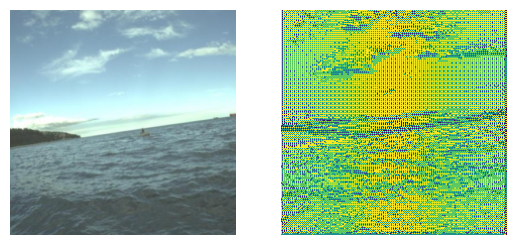

In [22]:
x_batch_sample, y_batch_sample = next(iter(val_dataloader))

with torch.no_grad():
  unet.eval()
  plt.subplot(1, 2, 1)
  plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
  plt.axis('off')

  pred = unet(x_batch_sample.to(DEVICE))
  plt.subplot(1, 2, 2)
  plt.imshow(torch.argmax(pred[0], dim=0).cpu().detach().numpy())
  plt.axis('off')
  unet.train()

## Loss

In [23]:
class FocalLoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 3, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    # # place mask over placeholder pixels (loss do not propagate through them)
    # mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))

    # y_true = (y_true * mask).squeeze(dim=1)
    # # one-hot encode labels
    # y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    # y_pred = y_pred * mask
    # focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    # loss = (focal_loss * mask).sum() / mask.sum()

    return loss


## Metric

In [24]:
# TODO: DICE accuracy

In [25]:
class AccuracyMetric(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, 3, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    accuracies = {}

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      accuracies[c] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in accuracies.values():
      avg_accuracy += a
    accuracies['avg'] = avg_accuracy / len(accuracies.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    accuracies['global'] = (diff*mask).sum() / mask.sum()

    return accuracies


## Bayes Forward

In [26]:
def bayes_forward(net, X:torch.tensor, k:int, buffer=None):
  '''
  Performs k forward passes with dropout layers, returns mean and std

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (3 x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes
  buffer (optional): torch.tensor(k x 3 x 224 x 224) buffer

  Returns
  -----------
  y_softmax            : torch.tensor (3 x 224 x 224)
  y_pred               : torch.tensor (224 x 224)
  y_pred_std_per_class : torch.tensor (3 x 224 x 224)
  y_pred_std_avg       : torch.tensor (224 x 224)
  '''
  if buffer is None:
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
  else:
    for i in range(k):
      # write image to buffer
      buffer[i] = X

  with torch.no_grad():
      net.eval()
      y_pred_raw = net(buffer)

  net.train()

  # Average the softmax (note that the resultant vectors are not normalised)
  y_softmax = y_pred_raw.mean(dim=0) # (3 x 224 x 224)
  # Take max prob as prediction
  y_pred = torch.argmax(y_softmax, dim=0).to(torch.int) # (224 x 224)
  # Per class uncertainty
  y_pred_std_per_class = y_pred_raw.exp().var(dim=0) # (3 x 224 x 224)
  # Average uncertainty over classes
  y_pred_std_avg = y_pred_std_per_class.mean(dim=0) # (224 x 224)

  return y_softmax, y_pred, y_pred_std_per_class, y_pred_std_avg

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [27]:
class TrainingManager():
  def __init__(self, dataloaders, config, net=None, ):
    self.dataloaders = dataloaders

    # hyperparameters from config
    self.weight_decay = config['weight_decay']
    self.lr = config['lr']
    self.k = config['k']
    self.encoder_dropout_config = config['encoder_dropout_config']
    self.decoder_dropout_config = config['decoder_dropout_config']

    if not net:
      encoder = Unet_MobileNetV2_Encoder(copy.deepcopy(mobileNet))
      decoder = Unet_MobileNetV2_Decoder(decoder_dropout_config)
      self.net = Unet_MobileNetV2(encoder, decoder).to(DEVICE)
      # dropout parameters
      self.net.toggle_dropout(True)
      self.net.update_dropout_config(encoder_dropout_config, decoder_dropout_config)
    else:
      self.net = copy.deepcopy(net).to(DEVICE)

    self.criterion = FocalLoss()
    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.epoch = 0
    self.history = {
        'loss/train': [],
        'loss/val': [],
        'loss/val_b': [],
        'loss/test': [],
        'acc/avg/train': [],
        'acc/avg/val': [],
        'acc/avg/val_b': [],
        'acc/avg/test': [],
        'acc/global/train': [],
        'acc/global/val': [],
        'acc/global/val_b': [],
        'acc/global/test': [],
    }

    for c in CLASS_MAP.values():
      self.history[f'acc/{c}/val'] = []
      self.history[f'acc/{c}/val_b'] = []
      self.history[f'acc/{c}/test'] = []

  def train(self, epochs, eval_mode='bayes'):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    self.net.toggle_dropout(True)

    for e in range(epochs):
      train_loss_epoch = 0
      train_global_acc_epoch = 0
      train_avg_acc_epoch = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_pred = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_pred)
        accs = self.metric(y_batch, y_pred)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_loss_epoch += loss * batch_size
        train_global_acc_epoch += accs['global'] * batch_size
        train_avg_acc_epoch += accs['avg'] * batch_size

      # log epoch loss and accuracy
      n_train = len(self.dataloaders['train'].dataset)
      self.history['loss/train'].append(train_loss_epoch/n_train)
      self.history['acc/global/train'].append(train_global_acc_epoch/n_train)
      self.history['acc/avg/train'].append(train_avg_acc_epoch/n_train)

      # run network on validation set
      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode)
      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for c in val_accs.keys():
          self.history[f'acc/{c}/val'].append(val_accs.get(c, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for c in val_accs_b.keys():
          self.history[f'acc/{c}/val_b'].append(val_accs_b.get(c, 0))

      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

  def _evaluate_regular(self, dataloader):
    self.net.eval()
    self.net.toggle_dropout(False)
    total_loss = 0
    total_accs = {}
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = self.net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)
        total_loss += loss * len(X)

        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc * len(X)

    n = len(dataloader.dataset)
    return total_loss/n, {k: v/n for k, v in total_accs.items()}

  def _evaluate_bayes(self, dataloader, k=None):
    if k == None:
      k = self.k

    buffer_tensor = torch.empty(size=(k, 3, 224, 224), dtype=torch.float32, device=DEVICE)

    self.net.toggle_dropout(True)
    self.net.update_dropout_config(self.encoder_dropout_config,
                                   self.decoder_dropout_config)

    total_loss = 0
    total_accs = {}
    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_pred, _, _, _ = bayes_forward(self.net, x, k, buffer_tensor)
        y_pred = y_pred.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)

        total_loss += loss
        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc

    n = len(dataloader.dataset)
    return total_loss/n, {k: v/n for k, v in total_accs.items()}

  def evaluate(self, eval_dataset='val', mode='bayes'):
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    loss, accs_b, loss_b, accs_b = 0, {}, 0, {}
    if mode == 'regular':
      loss, accs = self._evaluate_regular(self.dataloaders[eval_dataset])
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(self.dataloaders[eval_dataset])
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(self.dataloaders[eval_dataset])
      loss_b, accs_b = self._evaluate_bayes(self.dataloaders[eval_dataset])
    else:
      return

    return loss, accs, loss_b, accs_b

  def plot(self, save=False):
    '''
    Plots training history
    '''
    plt.figure(figsize=(16, 10))

    history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}

    x = list(range(1, self.epoch+1, 1))
    plt.subplot(2, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('Accuracy(g)')
    plt.plot(x, history['acc/global/train'], label='train',)
    plt.plot(x, history['acc/global/val'], label='val')
    plt.plot(x, history['acc/global/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('Accuracy(c)')
    plt.plot(x, history['acc/avg/train'], label='train',)
    plt.plot(x, history['acc/avg/val'], label='val')
    plt.plot(x, history['acc/avg/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    for i in range(3):
      plt.subplot(2, 3, 4+i)
      c_name = CLASS_MAP[i]
      plt.title(f'Accuracy({c_name})')
      # plt.plot(x, history[f'acc/{c_name}/train'], label='train',)
      plt.plot(x, history[f'acc/{c_name}/val'], label='val')
      plt.plot(x, history[f'acc/{c_name}/val_b'], label='val_b')
      plt.xlabel('epochs')
      plt.ylabel('acc')
      plt.legend()

    plt.show()

    if save:
      # TODO
      pass

    return

  def plot_acc_vs_k(self, ks=[1, 3, 5, 10, 15, 20, 25, 30, 35, 40], dataloader=None, num_repeats=5):
    '''
    plots accuracy vs k
    '''
    if dataloader is None:
      dataloader = self.dataloaders['val']

    # evaluate bayesian forward for different ks
    losses, accs_g, accs_a = [], [], []
    losses_std, accs_g_std, accs_a_std = [], [], []
    print('evaluating...')

    for k in tqdm(ks):
      loss, acc_g, acc_a = [], [], []
      for i in range(num_repeats):
        l, a = self._evaluate_bayes(dataloader, k)
        loss.append(l.cpu().detach())
        acc_g.append(a['global'].cpu().detach())
        acc_a.append(a['avg'].cpu().detach())
      loss, acc_g, acc_a = np.array(loss), np.array(acc_g), np.array(acc_a)
      losses.append(loss.mean())
      losses_std.append(loss.std())
      accs_g.append(acc_g.mean())
      accs_g_std.append(acc_g.std())
      accs_a.append(acc_a.mean())
      accs_a_std.append(acc_a.std())

      # print(f'{k}: {loss}, {accs['global']}, {accs['avg']}')

    # weight averaging (i.e. regular)
    loss, accs = self._evaluate_regular(dataloader)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Loss')
    plt.errorbar(ks, losses, yerr=losses_std, label='Bayes')
    plt.plot(ks, [loss.cpu().detach()]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, accs_g, yerr=accs_g_std, label='Bayes')
    plt.plot(ks, [accs['global'].cpu().detach()]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, accs_a, yerr=accs_a_std, label='Bayes')
    plt.plot(ks, [accs['avg'].cpu().detach()]*len(ks), label='WA')
    plt.legend()

    return

  def _save_model(self, ):
    pass

  def _save_logs(self, ):
    pass

  def save(self, ):
    pass




# Result Summary

This class summarises training stats across many runs and has a plotting function to show the results

# Experiments Section

### Baseline

In [28]:
torch.cuda.empty_cache()

In [29]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : [0, 0, 0, 0.5, 0.5],
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager = TrainingManager(dataloaders, config)

In [30]:
training_manager.evaluate(mode='all')
# training_manager.plot_acc_vs_k()

(tensor(1.1643, device='cuda:0'),
 {'obstacle': tensor(0.4132, device='cuda:0'),
  'ground': tensor(0.2227, device='cuda:0'),
  'sky': tensor(0.4905, device='cuda:0'),
  'avg': tensor(0.3754, device='cuda:0'),
  'global': tensor(0.3760, device='cuda:0')},
 tensor(1.1640, device='cuda:0'),
 {'obstacle': tensor(0.4127, device='cuda:0'),
  'ground': tensor(0.2227, device='cuda:0'),
  'sky': tensor(0.4907, device='cuda:0'),
  'avg': tensor(0.3754, device='cuda:0'),
  'global': tensor(0.3761, device='cuda:0')})

In [31]:
training_manager.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Train: Acc(g) = 89.7714, Loss = 0.3359
Val: Acc(g) = 96.0903, Acc(c) = 89.7927, Loss = 0.1429
Bayes_validation: Acc = 97.0136, Acc(c) = 91.8136, Loss = 0.1362


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Train: Acc(g) = 96.2705, Loss = 0.1415
Val: Acc(g) = 97.5267, Acc(c) = 93.1352, Loss = 0.0872
Bayes_validation: Acc = 97.7591, Acc(c) = 94.1621, Loss = 0.0881


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Train: Acc(g) = 96.9275, Loss = 0.1059
Val: Acc(g) = 98.0232, Acc(c) = 94.7172, Loss = 0.0668
Bayes_validation: Acc = 98.1471, Acc(c) = 95.6433, Loss = 0.0698


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Train: Acc(g) = 97.2967, Loss = 0.0880
Val: Acc(g) = 97.9928, Acc(c) = 94.2433, Loss = 0.0619
Bayes_validation: Acc = 98.2601, Acc(c) = 95.3955, Loss = 0.0590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Train: Acc(g) = 97.5199, Loss = 0.0775
Val: Acc(g) = 98.3187, Acc(c) = 95.2168, Loss = 0.0509
Bayes_validation: Acc = 98.4600, Acc(c) = 96.0448, Loss = 0.0510


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Train: Acc(g) = 97.7675, Loss = 0.0678
Val: Acc(g) = 98.5462, Acc(c) = 96.1112, Loss = 0.0431
Bayes_validation: Acc = 98.5898, Acc(c) = 96.6281, Loss = 0.0443


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Train: Acc(g) = 97.7831, Loss = 0.0661
Val: Acc(g) = 98.4902, Acc(c) = 96.9599, Loss = 0.0447
Bayes_validation: Acc = 98.3672, Acc(c) = 97.4033, Loss = 0.0495


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Train: Acc(g) = 97.9398, Loss = 0.0604
Val: Acc(g) = 98.6134, Acc(c) = 96.0777, Loss = 0.0400
Bayes_validation: Acc = 98.5567, Acc(c) = 96.5689, Loss = 0.0431


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Train: Acc(g) = 98.0662, Loss = 0.0562
Val: Acc(g) = 98.5764, Acc(c) = 95.6695, Loss = 0.0403
Bayes_validation: Acc = 98.5061, Acc(c) = 96.0403, Loss = 0.0437


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Train: Acc(g) = 98.0721, Loss = 0.0555
Val: Acc(g) = 98.7726, Acc(c) = 96.9249, Loss = 0.0346
Bayes_validation: Acc = 98.7183, Acc(c) = 97.1061, Loss = 0.0368


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11
Train: Acc(g) = 98.1798, Loss = 0.0520
Val: Acc(g) = 98.7984, Acc(c) = 96.5688, Loss = 0.0333
Bayes_validation: Acc = 98.8294, Acc(c) = 97.0170, Loss = 0.0342


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12
Train: Acc(g) = 98.1866, Loss = 0.0516
Val: Acc(g) = 98.8801, Acc(c) = 96.9971, Loss = 0.0311
Bayes_validation: Acc = 98.8942, Acc(c) = 97.3181, Loss = 0.0324


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Train: Acc(g) = 98.2514, Loss = 0.0494
Val: Acc(g) = 98.8802, Acc(c) = 97.0930, Loss = 0.0315
Bayes_validation: Acc = 98.8871, Acc(c) = 97.4931, Loss = 0.0327


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14
Train: Acc(g) = 98.3010, Loss = 0.0480
Val: Acc(g) = 98.9780, Acc(c) = 97.5265, Loss = 0.0283
Bayes_validation: Acc = 98.9719, Acc(c) = 97.8255, Loss = 0.0300


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Train: Acc(g) = 98.3541, Loss = 0.0467
Val: Acc(g) = 98.7626, Acc(c) = 96.6068, Loss = 0.0338
Bayes_validation: Acc = 98.8238, Acc(c) = 96.8372, Loss = 0.0331


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16
Train: Acc(g) = 98.3529, Loss = 0.0466
Val: Acc(g) = 98.7416, Acc(c) = 96.8732, Loss = 0.0350
Bayes_validation: Acc = 98.5906, Acc(c) = 96.8523, Loss = 0.0394


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17
Train: Acc(g) = 98.4345, Loss = 0.0439
Val: Acc(g) = 98.9154, Acc(c) = 97.3788, Loss = 0.0296
Bayes_validation: Acc = 98.8832, Acc(c) = 97.5181, Loss = 0.0311


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18
Train: Acc(g) = 98.4508, Loss = 0.0433
Val: Acc(g) = 98.5215, Acc(c) = 94.6153, Loss = 0.0391
Bayes_validation: Acc = 98.3038, Acc(c) = 93.8605, Loss = 0.0451


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19
Train: Acc(g) = 98.5130, Loss = 0.0419
Val: Acc(g) = 98.9947, Acc(c) = 97.5553, Loss = 0.0270
Bayes_validation: Acc = 99.0254, Acc(c) = 97.8410, Loss = 0.0273


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Train: Acc(g) = 98.5444, Loss = 0.0409
Val: Acc(g) = 99.0549, Acc(c) = 97.8206, Loss = 0.0255
Bayes_validation: Acc = 99.0794, Acc(c) = 97.9818, Loss = 0.0259


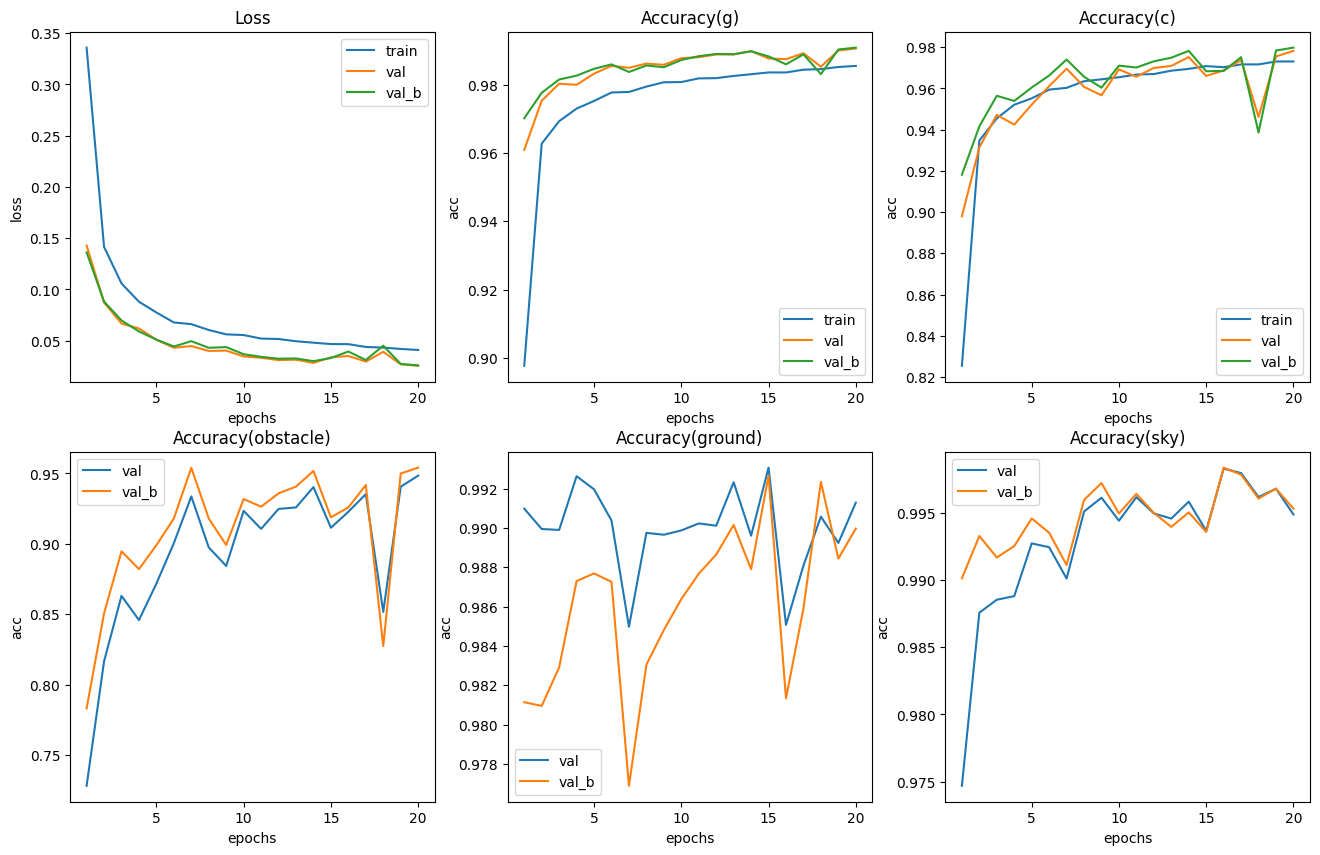

In [32]:
training_manager.plot()

evaluating...


  0%|          | 0/10 [00:00<?, ?it/s]

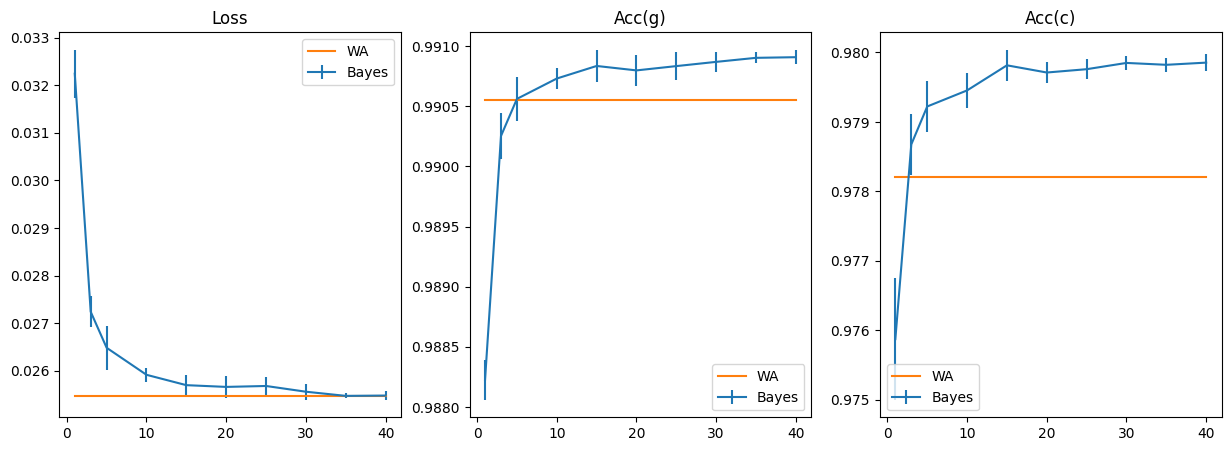

In [33]:
training_manager.plot_acc_vs_k()

### Less dropout

In [ ]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager2 = TrainingManager(dataloaders, config)

In [ ]:
# training_manager2.train(epochs=20, eval_mode='all')

In [ ]:
training_manager2.plot()

evaluating...


  0%|          | 0/10 [00:00<?, ?it/s]

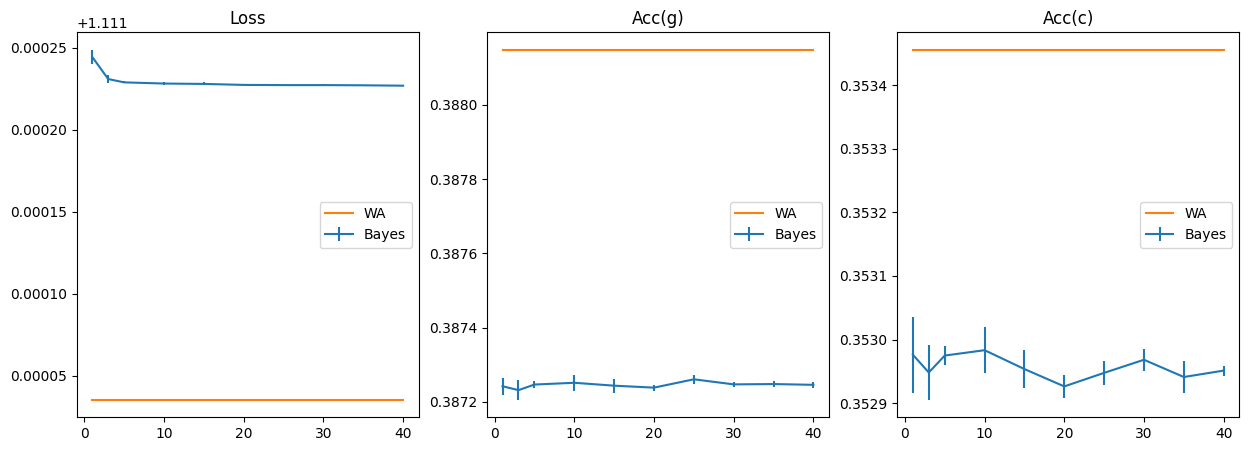

In [ ]:
training_manager2.plot_acc_vs_k()

## Qualitative performance

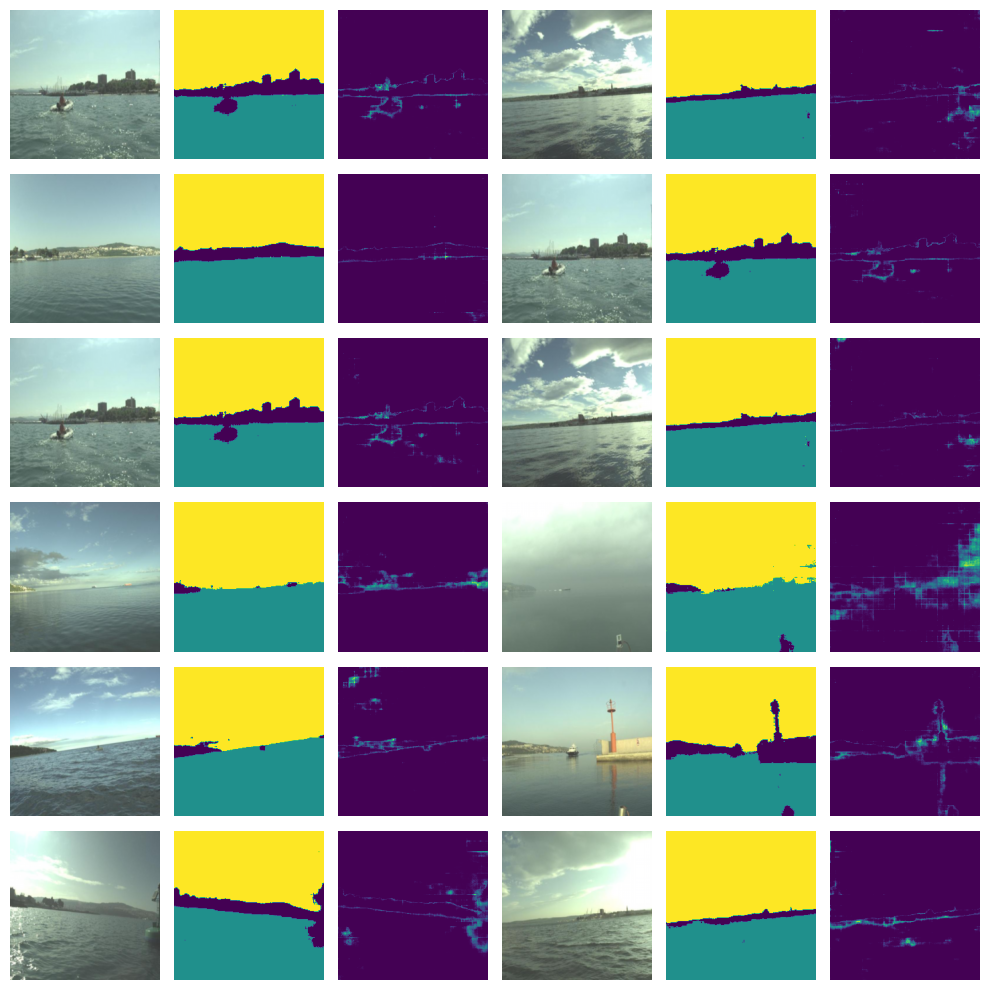

In [46]:
exp = training_manager
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 10

for i in range(6):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  plt.imshow(y_std.cpu())
  plt.axis('off')

  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+4)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()

### Per class uncertainty

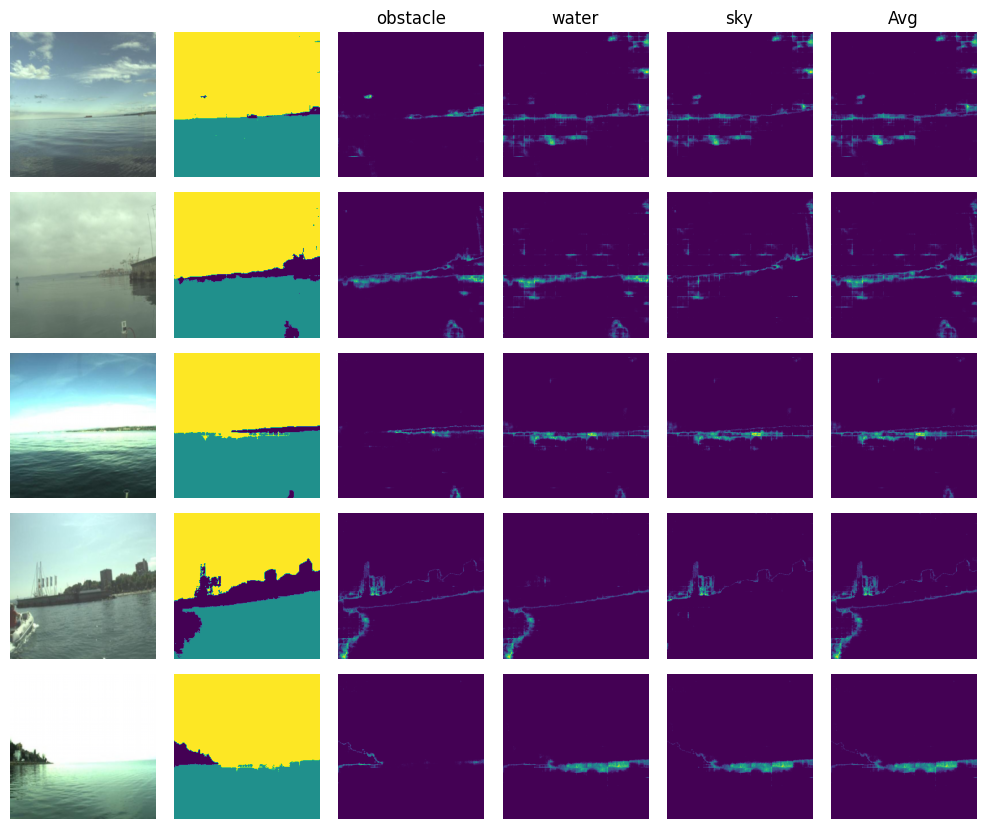

In [45]:
exp = training_manager
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 20

for i in range(5):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, y_stds, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  if i == 0:
    plt.title(f'{CLASS_MAP[0]}')
  plt.imshow(y_stds[0].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+4)
  if i == 0:
    plt.title(f'{CLASS_MAP[1]}')
  plt.imshow(y_stds[1].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  if i == 0:
    plt.title(f'{CLASS_MAP[2]}')
  plt.imshow(y_stds[2].cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  if i == 0:
    plt.title(f'Avg')
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()